In [1]:
# brew install graphviz
%pip install graphviz
%reset -f
from graphviz import Digraph

/bin/bash: /home/kostas/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op.name, label=n._op.name)
            dot.edge(str(id(n)) + n._op.name, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op.name)
    
    return dot

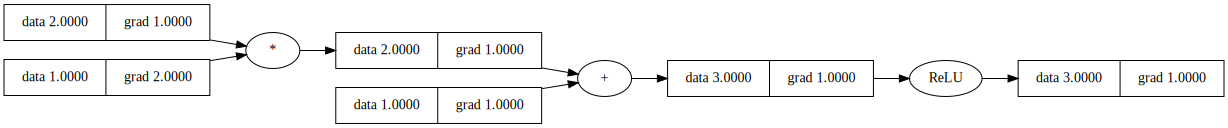

In [3]:
from micrograd.engine import Value

# a very simple example
x = Value(1.0)
z=x+3
y = (x * 2 + 1).relu()
draw_dot(y)
y.backward()
draw_dot(y)

In [ ]:
from IPython.display import Image

def draw_dot_highlight(root, highlight=None, parent_op=None, format='svg', rankdir='LR'):
    """
    Draws the computation graph, highlighting the node if provided.
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'margin': '0.5'})
    for n in nodes:
        color = 'white'
        if highlight is not None and n in highlight:
            color = 'yellow'
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record', 
                 style='filled', fillcolor=color)
        if n._op:
            if n._op is not parent_op:
                dot.node(name=str(id(n)) + n._op.name, label=n._op.name)
                dot.edge(str(id(n)) + n._op.name, str(id(n)))
            else:
                dot.node(name=str(id(n)) + n._op.name, label=n._op.name, style='filled', fillcolor='red')
                dot.edge(str(id(n)) + n._op.name, str(id(n)), color='red', penwidth='2')
    for n1, n2 in edges:
        if n1 in highlight and n2._op == parent_op:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op.name, color='red', penwidth='2')
        else:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op.name)
    return dot

# Animate backward pass and save as SVG animation
frames = []
def collect_frame(nodes, parent_op, root):
    dot = draw_dot_highlight(root, highlight=nodes, parent_op=parent_op)
    svg_bytes = dot.pipe(format='svg')
    if svg_bytes:
        frames.append(svg_bytes.decode('utf-8'))  # decode to string for SVG concatenation

def save_animation(output_filename, frames):
    if not frames:
        print('No frames generated. Check if backward pass is working and callback is called.')
    else:
        # Save animation as a multi-frame SVG (using <g> groups and <animate> for simple effect)
        svg_header = '<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n'
        svg_frames = [f[ f.find('<svg') : f.rfind('</svg>')+6 ] for f in frames if '<svg' in f and '</svg>' in f]

        if not svg_frames:
            print('No valid SVG frames found.')
        else:
            # Extract width/height from first frame
            import re
            m = re.search(r'<svg[^>]*width="([^"]+)"[^>]*height="([^"]+)"', svg_frames[0])
            width = m.group(1) if m else '800pt'
            height = m.group(2) if m else '600pt'
            # Add extra height for the slider
            height_num = int(float(height.replace('pt','')))
            slider_height = 60
            new_height = f"{height_num + slider_height}pt"

            # Compose SVG with all frames as <g> elements, only one visible at a time
            svg_out = [svg_header, f'<svg width="{width}" height="{new_height}" xmlns="http://www.w3.org/2000/svg">']
            for i, frame in enumerate(svg_frames):
                # Remove outer <svg> tags
                content = re.sub(r'<svg[^>]*>|</svg>', '', frame, flags=re.DOTALL)
                display_val = 'inline' if i == 0 else 'none'
                svg_out.append(f'<g id="frame{i}" style="display:{display_val}">{content}</g>')

            # Add slider and JS for speed control at the bottom
            svg_out.append(f'''
                <foreignObject x="10" y="{height_num + 10}" width="300" height="50">
                <body xmlns="http://www.w3.org/1999/xhtml">
                    <label>Speed: <input id="speedSlider" type="range" min="100" max="2000" value="700" step="100"/>
                    <span id="speedValue">700</span> ms</label>
                </body>
                </foreignObject>
                <script type="text/ecmascript"><![CDATA[
                var n = {len(svg_frames)};
                var i = 0;
                var interval = 1000;
                var timer = null;
                function showFrame(idx) {{
                for (var j = 0; j < n; ++j) {{
                    document.getElementById('frame'+j).style.display = (j==idx?'inline':'none');
                }}
                }}
                function startAnimation() {{
                if (timer) clearInterval(timer);
                timer = setInterval(function(){{
                    i = (i+1)%n;
                    showFrame(i);
                }}, interval);
                }}
                var slider = document.getElementById('speedSlider');
                var speedValue = document.getElementById('speedValue');
                slider.addEventListener('input', function() {{
                interval = parseInt(slider.value);
                speedValue.textContent = interval;
                startAnimation();
                }});
                startAnimation();
                ]]></script>
                ''')
            svg_out.append('</svg>')
            with open(output_filename, 'w') as f:
                f.write(''.join(svg_out))

            print(f'SVG animation saved as {output_filename}')
            # display image using url and specific width set at 500
            # Image(url=output_filename, width=500)


SVG animation saved as backprop_animated.svg


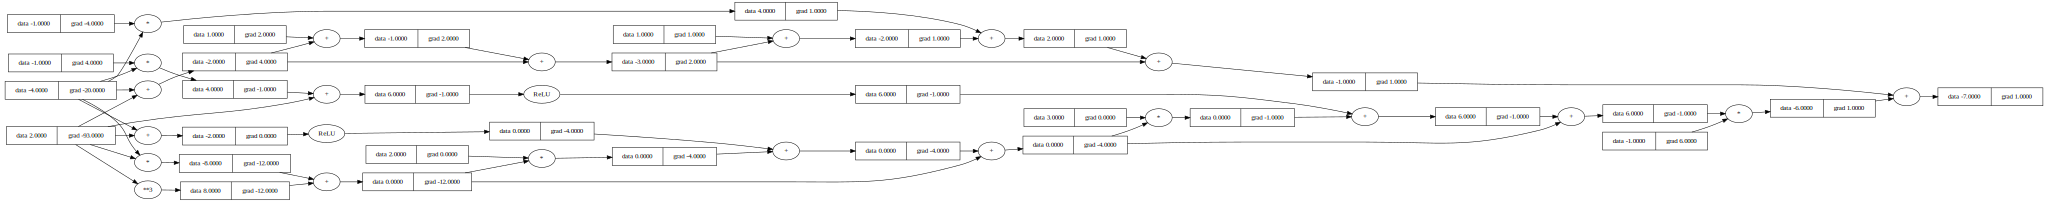

In [5]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d

frames.clear()
e.backward(callback=collect_frame)

save_animation('backprop_animated.svg', frames)
draw_dot(e)

In [ ]:
# a simple 2D neuron
import random
from micrograd import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [ ]:
dot.render('gout')